# RO 09
Franziska Boenisch / Christoph Brockmann
## Task 1 a/b:

In [1]:
#!/usr/bin/env python
# coding: utf-8
# imports

import sys
import math
import roslib
import rospy
import cv2
import numpy as np

from std_msgs.msg import String
from sensor_msgs.msg import Image
from sensor_msgs.msg import CompressedImage

from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, PoseArray, Quaternion, Twist, Vector3 

from cv_bridge import CvBridge, CvBridgeError
from matplotlib import pyplot as plt

In [2]:
%matplotlib nbagg

### Plotter-Class for live-Updates:

In [3]:
# from Mustererkennung 

class Plotter(object):
    
    def __init__(self, xlabel='X', ylabel='Y', jup=False):
        self.active = False
        self.fig = None
        self.ax = None
        self.xlabel = xlabel
        self.ylabel = ylabel
        # run in a Jupyter notebook ?
        self.jup = jup
        
        # for particle plots
        self.scatter = None
    
    def plot(self, data):
        # assume data comes in [x0, y0, x1, y1, ... xn, yn] collums per row
        r, c = data.shape
        num_sets = c//2
        colors = ['green', 'red', 'blue', 'cyan']
        
        if not self.active:
            # setup a new plot
            self.fig, self.ax = plt.subplots(1,1)
            self.ax.set_xlabel(self.xlabel, fontsize=12)
            self.ax.set_ylabel(self.ylabel, fontsize=12)
            
            for s in range(num_sets):
                x = s*2
                y = x+1
                self.ax.plot(data[:,x], data[:,y], color=colors[s], alpha=1.0)

            plt.show(block = False)
            self.active = True

        else:
            # add new data to the existing plot
            for s in range(num_sets):
                x = s*2
                y = x+1
                line = self.ax.lines[s]
                line.set_xdata(data[:,x])
                line.set_ydata(data[:,y])
                
        self.fig.canvas.draw()
        
        # if drawing in an external window
        if not self.jup:
            self.fig.canvas.flush_events()
        
        # reset axis to accomodate new data
        self.ax.relim()
        self.ax.autoscale_view()
    
    def plotparts(self, data):
        # data is [parts, w, data] where parts = N x [x,y,theta] , w = N x 1, data = as before
        parts = data[0]
        w = data[1]
        data = np.array(data[2])
        r, c = data.shape
        num_sets = c//2
        colors = ['green', 'red', 'blue', 'cyan']
        
        if not self.active:
            # setup a new plot
            self.fig, self.ax = plt.subplots(1,1)
            self.ax.set_xlabel(self.xlabel, fontsize=12)
            self.ax.set_ylabel(self.ylabel, fontsize=12)
            #self.ax.set_xlim(-1, 9)
            #self.ax.set_ylim(-1, 9)
            
            # plot particles
            self.quivers = self.ax.quiver(parts[:,0], parts[:,1], 
                                          np.cos(parts[:,2]), np.sin(parts[:,2]), 
                                          w, pivot='mid')
            
            # plot lines
            for s in range(num_sets):
                x = s*2
                y = x+1
                self.ax.plot(data[:,x], data[:,y], color=colors[s], alpha=1.0)

            plt.show(block = False)
            self.active = True

        else:
            # add new data to the existing plot
            self.quivers.remove()
            self.quivers = self.ax.quiver(parts[:,0], parts[:,1], 
                                          np.cos(parts[:,2]), np.sin(parts[:,2]), 
                                          w, pivot='mid')
            for s in range(num_sets):
                x = s*2
                y = x+1
                line = self.ax.lines[s]
                line.set_xdata(data[:,x])
                line.set_ydata(data[:,y])
            
                
        self.fig.canvas.draw()      
        
        # if drawing in an external window
        if not self.jup:
            self.fig.canvas.flush_events()
        
        # reset axis to accomodate new data
        self.ax.relim()
        self.ax.autoscale_view()

    def save(self, filename):
        self.fig.savefig(filename)   

In [4]:
# functions
def angle(pos, pos1, pos2):
    # relative angle of two vectors
    v1 = (pos1 - pos)/np.linalg.norm(pos1 - pos)
    v2 = (pos2 - pos)/np.linalg.norm(pos2 - pos)
    
    return np.arccos(v1.dot(v2.T))

def rot_angle(pos, pos1):
    # rotation angle to x axis from [0, 2pi]
    v = pos1 - pos
    a = np.arctan2(v[1], v[0])
    if a > 0:
        return a
    else:
        return (2 * np.pi) + a


def ori(p1, p2, p3):
    return (p2[0]-p1[0])*(p3[1]-p1[1])-(p3[0]-p1[0])*(p2[1]-p1[1])

def get_bulb_pos(image):
        y_dim = image.shape[0]
        x_dim = image.shape[1]    
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        r = 190; r_s = 20
        #r = 128; r_s = 127
        b = 130; b_s = 40
        g = 60;  g_s = 20
        
        s_low = 150; s_high = 255
        v_low = 30; v_high = 255        # the image says ca 200
        
        lower_r = np.array([r-r_s,s_low,v_low])
        upper_r = np.array([r+r_s,s_high,v_high])
        
        lower_b = np.array([b-b_s,s_low,v_low])
        upper_b = np.array([b+b_s,s_high,v_high])
        
        lower_g = np.array([g-g_s,s_low,v_low])
        upper_g = np.array([g+g_s,s_high,v_high])

        """
        IDEE: 
        benutze Masken für rot grün und blau/purple
        fitte 1, 1 und 2 Punkte (größte)
        benutze ori(p1,p2,p3) um blau und purple zu unterscheiden
        benutze interne Distanzen (oder ori) um Sinnhaftigkeit der Punkte zu beurteilen
        """
        
        # fit by color        
        pos_g, mask_g = getblobs(hsv, lower_g, upper_g, n=1)
        pos_r, mask_r = getblobs(hsv, lower_r, upper_r, n=1)       
        pos_b1, pos_b2, mask_b = getblobs(hsv, lower_b, upper_b, n=2)
        pos_b = pos_p = None
        
        # test if I have data for all bulbs
        if not None in (pos_g, pos_r, pos_b1, pos_b2):
            
            # assign blue and purple by orientation test
            if ori(pos_g, pos_r, pos_b1) > 0:
                pos_b = pos_b1
                pos_p = pos_b2
            else:
                pos_b = pos_b2
                pos_p = pos_b1
        
        else:
            # TODO: fix alg for missing bulbs
            pass
        
        # return positions
        return pos_r, pos_g, pos_b, pos_p

def getblobs(img, lower, upper, n=1):
    mask = cv2.inRange(img, lower, upper)
    
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)
    #mask = cv2.dilate(mask, kernel, iterations=1)
    
    im2, contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # get the two larges contours as lanes:
    contour_a = [None, None]
    first_size = 0
    secnd_size = 0

    for contour in contours:
        test = cv2.contourArea(contour)
        if test > first_size:
            contour_a[1] = contour_a[0]
            secnd_size = first_size
            contour_a[0] = contour
            first_size = test
        elif test > secnd_size:
            contour_a[1] = contour
            secnd_size = test
    
    p1_points = contour_a[0]
    if p1_points is None:
        p1 = None
    else:
        p1 = np.zeros((2))        
        p1[0] = np.average(p1_points[:,:,1])
        p1[1] = np.average(p1_points[:,:,0])
        
    if n == 1:
        return p1, mask
    else:
        p2_points = contour_a[1]
        if p2_points is None:
            p2 = None
        else:
            p2 = np.zeros((2))
            p2[0] = np.average(p2_points[:,:,1])
            p2[1] = np.average(p2_points[:,:,0])
        return p1, p2, mask

def yaw_to_quaternion(yaw):
    """convert a yaw angle (in radians) into a Quaternion message"""
    return Quaternion(0, 0, math.sin(yaw / 2), math.cos(yaw / 2))

def quaternion_to_yaw(quaternion):
    return np.arccos(quaternion.w) * 2 * np.sign(quaternion.z)

def build_Odometry(position, yaw):
    # Build and publish Odometry as in:
    # https://gist.github.com/atotto/f2754f75bedb6ea56e3e0264ec405dcf
    x = position[0]
    y = position[1]

    odom = Odometry()
    odom.header.stamp = rospy.Time.now()
    odom.header.frame_id = "odom"

    # set the position
    odom.pose.pose = Pose(Point(x, y, 0.), yaw_to_quaternion(yaw))
                
    # set the velocity
    odom.child_frame_id = "base_link"
    return odom

def read_pose(pose, corr=False):
    if corr:
        x =  - pose.position.x
        y = pose.position.y
        yaw = np.pi - quaternion_to_yaw(pose.orientation)
    else:
        x = pose.position.x
        y = pose.position.y
        yaw = quaternion_to_yaw(pose.orientation)
    
    return x, y, yaw

def gaussian(x, sigma):
    exponent = -(x**2)/(2*(sigma**2))
    teiler   = np.sqrt(2* np.pi)
    return(np.exp(exponent)/teiler)

## Task 1

In [ ]:
def parts_to_posearray(parts):
    # takes a n x 3 array encoding x, y, yaw for n particles 
    # return PoseArray Message
    N = parts.shape[0]
    posearray = PoseArray()
    posearray.header.stamp = rospy.Time.now()
    posearray.header.frame_id = "odom"
    
    for i in range(N):
        part = parts[i]
        x, y, yaw = part[0], part[1], part[2]
        #print(x, y, yaw)
        pose = Pose(Point(x, y, 0.), yaw_to_quaternion(yaw))
        posearray.poses.append(pose)
    
    return posearray        

## The Node

<IPython.core.display.Javascript object>


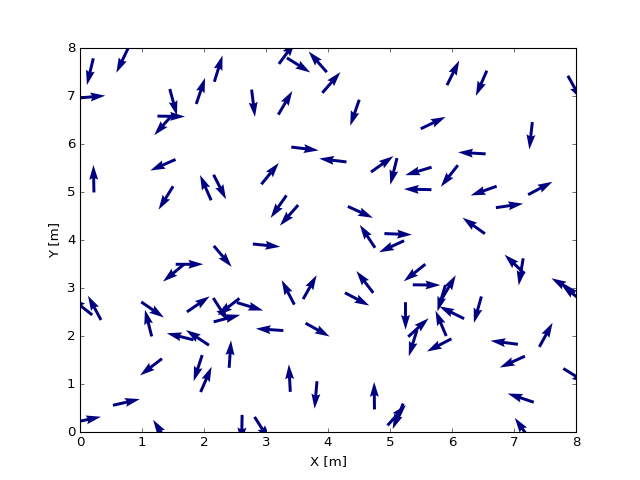

<IPython.core.display.Javascript object>


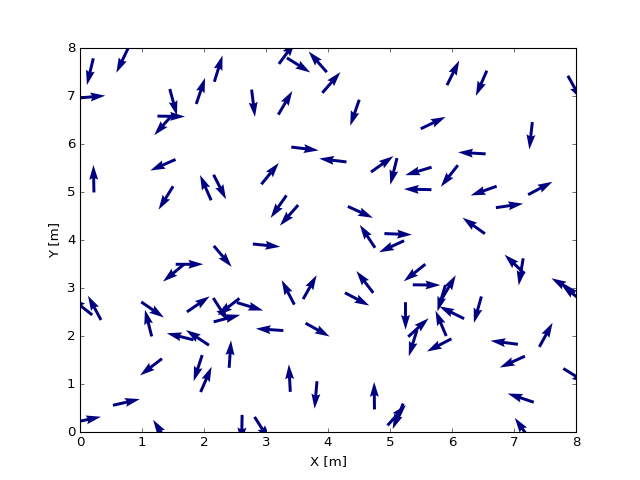

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:208: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:61: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


<IPython.core.display.Javascript object>


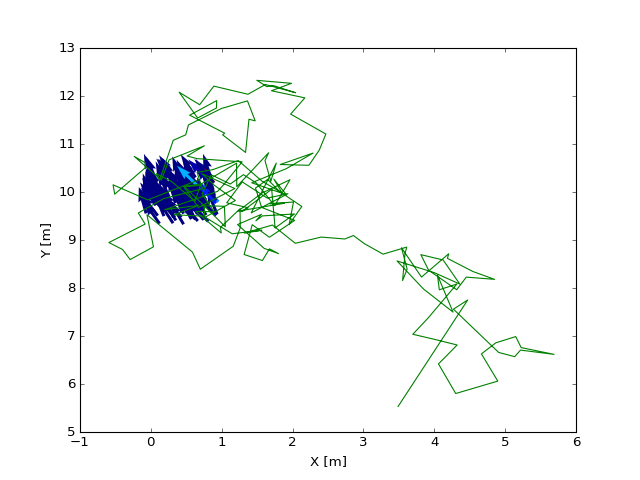

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# class structure analog to https://github.com/richrdcm/catkin_ws_user/tree/master/src/py_image_processing

class PartFilter:

    def __init__(self):
        
        # properties of filter
        self.N = 100
        self.sigma = 0.5    # was 0.1 
        self.pos_noise = 0.5
        self.yaw_noise = 0.3
        
        #properties of the grid
        self.x_size = 8.0
        self.y_size = 8.0
        self.x_ori = 0
        self.y_ori = 0
        
        self.bridge = CvBridge()
        # are images compressed?
        self.compressed = True
        
        # publisher topics
        # self.odom_pub = rospy.Publisher("odom_gps", Odometry, queue_size=50)
        self.mcpf_pub = rospy.Publisher("mcpf_gps", Odometry, queue_size=50)
        self.posearray_pub = rospy.Publisher("/mcposearray", PoseArray, queue_size=50)
        
        # subscriber topics        
        if self.compressed: 
            self.image_sub = rospy.Subscriber("/usb_cam/image_rect_color/compressed", CompressedImage, self.update, queue_size=1)
        else:
            self.image_sub = rospy.Subscriber("/usb_cam/image_rect_color", Image, self.update, queue_size=1)        
        self.odom_sub = rospy.Subscriber("odom", Odometry, self.predict, queue_size=1)
        
        # for plotting
        self.plotter = Plotter(xlabel='X [m]', ylabel='Y [m]', jup=True)
        self.data  = []
        
        # Assignment documentation switches
        self.doc = True          # do we document?
        self.firstpred = True    # is predict() run for the first time?

        
        # setup the angle map
        """
        # old setup
        pos_r = np.array([3.57, 3.00]) 
        pos_g = np.array([2.33, 1.15])
        pos_b = np.array([3.57, 1.15])
        pos_p = np.array([2.33, 3.00])
        """
        
        # new setup
        self.pos_r = np.array([3.55, 3.03]) 
        self.pos_g = np.array([2.29, 1.14])
        self.pos_b = np.array([4.18, 1.77])
        self.pos_p = np.array([2.29, 2.40])
        
        # to correct one angle to 0
        self.angle_corr = rot_angle(self.pos_r, self.pos_g)
        
        self.count = 0
                        
        # some memory of things used for the alg.
        self.last_odom_pose = None
        self.last_odom_time = None
        self.last_odom_gps_pose = None
        self.last_odom_gps_time = None
        
        self.x_pred = None
        self.y_pred = None
        self.theta_pred = None
        self.v = None
        
        # remember offset of first odometry / odometry_gps pair
        self.x_off = None
        self.y_off = None
        self.theta_off = None
        
        #-----------------------------------------------------------------------------
        # Task 1: initialize the particles
        #-----------------------------------------------------------------------------
        self.parts = np.random.rand(self.N, 3)
        self.parts[:,0] *= self.x_size
        self.parts[:,0] -= self.x_ori
        self.parts[:,1] *= self.y_size
        self.parts[:,1] -= self.y_ori
        self.parts[:,2] *= 2*np.pi
        
        self.posearray_pub.publish(parts_to_posearray(self.parts))
        if self.doc:
            plotter1 = Plotter(xlabel='X [m]', ylabel='Y [m]', jup=True)
            plotter1.plotparts([self.parts, np.zeros((self.N, 1)), [[0,0]]])
            plotter1.save('Task_1_init_parts.png')
            
    def localize(self, w):
        #--------------------------------------------------------------------------
        # Task 5
        #--------------------------------------------------------------------------
        
        # get weighted average position
        pos = np.sum((self.parts * w), axis=0)
        
        # that of course produces garbage for angles, so we do it better
        pos[2] = np.arctan2(np.sum(np.sin(self.parts[:,2]) * w), np.sum(np.cos(self.parts[:,2]) * w))
        
        # match to a [0, 2pi] range  
        if pos[2] < 0:
            pos[2] = 2*np.pi - pos[2]
        
        return pos
    
    def predict(self, odom):
        #--------------------------------------------------------------------------
        # Task 2
        #--------------------------------------------------------------------------

        
        if self.last_odom_pose is not None:
            
            #--------------------------------------------------------------------------
            # Task 2
            #--------------------------------------------------------------------------
                            
            # read data (no need to correct)
            last_x_o, last_y_o, last_theta_o = read_pose(self.last_odom_pose, corr=True)
            x_o, y_o, theta_o = read_pose(odom.pose.pose, corr=True)
                
            # get time difference
            d_t = (odom.header.stamp - self.last_odom_time).to_sec()
            d_x = x_o - last_x_o
            d_y = y_o - last_y_o
            v = np.linalg.norm([d_x, d_y]) / d_t

            # get the change in position from v, yaw
            delta_x = v * math.cos(last_theta_o) * d_t
            delta_y = v * math.sin(last_theta_o) * d_t
            delta_theta = theta_o - last_theta_o

            # implement the formulas
            self.parts[:,0] += delta_x
            self.parts[:,1] += delta_y
            self.parts[:,2] += delta_theta
            self.v = v
            self.v_theta = delta_theta / d_t

            # store new data for later
            # there are Point pose.position and Quaternion pose.orientation
            self.last_odom_pose = odom.pose.pose
            self.last_odom_time = odom.header.stamp
            
            if self.doc and self.firstpred:
                plotter2 = Plotter(xlabel='X [m]', ylabel='Y [m]', jup=True)
                plotter2.plotparts([self.parts, np.zeros((self.N, 1)), [[0,0]]])
                plotter2.save('Task_2_prop_parts.png')
                
                self.firstpred = False
            
        
        else:
            # just populate the last pose
            self.last_odom_pose = odom.pose.pose
            self.last_odom_time = odom.header.stamp

            
    def extend(self, time):
        """
        extend prediction to timepoint time
        """        
        # read old data (no need to correct)
        last_x_o, last_y_o, last_theta_o = read_pose(self.last_odom_pose, corr=True)
                                
        # get time difference
        d_t = (time - self.last_odom_time).to_sec()
        delta_x = self.v * math.cos(last_theta_o) * d_t
        delta_y = self.v * math.sin(last_theta_o) * d_t
        delta_theta = self.v_theta * d_t

        # implement the formulas
        self.parts[:,0] + delta_x
        self.parts[:,1] + delta_y
        self.parts[:,2] + delta_theta
        
        self.last_odom_time = time
            

    def update(self, data):
        """
        Reads next bulb camera image and updates position accordingly. data is a image message
        """
        t = data.header.stamp
        
        # get the image -------------------------------------------------------
        try:
            if self.compressed:
                cv_image = self.bridge.compressed_imgmsg_to_cv2(data, "bgr8")
            else:
                cv_image = self.bridge.imgmsg_to_cv2(data, "bgr8")
        except CvBridgeError as e:
            print(e)

        pos_r, pos_g, pos_b, pos_p = get_bulb_pos(cv_image)
        
        # TODO: for now, test if I have data for all bulbs
        if None not in (pos_r, pos_g, pos_b, pos_p):
            
            ori = np.array([0., 0.])
            
            ang_c = np.array([rot_angle(ori, pos_r),
                              rot_angle(ori, pos_g),
                              rot_angle(ori, pos_b),
                              rot_angle(ori, pos_p)])
            
            # TODO: corrections ? are we looking towards the x axis?
            ang_c += 0
    
            # Which direction is yaw = 0 ???
            yaw = rot_angle(pos_r, pos_g) - self.angle_corr + 3 * (np.pi/2)
            
            # extend
            # self.extend(t)
             
            #--------------------------------------------------------------------------
            # Task 3: calc weights
            #--------------------------------------------------------------------------
            w = self.getweights(ang_c)
            
            #--------------------------------------------------------------------------
            # Task 5: get position
            #--------------------------------------------------------------------------    
            position = self.localize(w)
                        
            # plot position
            x = position[0]
            y = position[1]
            self.data.append([x, y])
            #self.plotter.plot(np.array(self.data))
            
            #plot particles            
            self.plotter.plotparts([self.parts, w, self.data])
                        
            # publish the messages
            odom = build_Odometry(position[:2], position[2])
            self.mcpf_pub.publish(odom)
            # self.posearray_pub.publish(parts_to_posearray(self.parts))
            
            # store new info for now
            self.last_odom_gps_pose = odom.pose.pose
            self.last_odom_gps_time = odom.header.stamp
            
            #--------------------------------------------------------------------------
            # Task 4: resample
            #--------------------------------------------------------------------------
            self.resample(w)
    
    def getweights(self, ang_c):
        #--------------------------------------------------------------------------
        # Task 3
        #--------------------------------------------------------------------------

        ang_m = np.zeros((self.N, 4))
        
        # populate 
        for i in range(self.N):
            ang_m[i, :] = np.array([rot_angle(self.parts[i, 0:2], self.pos_r),
                                    rot_angle(self.parts[i, 0:2], self.pos_g),
                                    rot_angle(self.parts[i, 0:2], self.pos_b),
                                    rot_angle(self.parts[i, 0:2], self.pos_p)])
            # This correct?
            ang_m[i, :] -= self.parts[i, 2]
        
        # do the formula, takes smallest angle
        diff = ang_m - ang_c
        diff[diff > np.pi] = np.pi - diff[diff > np.pi]
        
        w_m = np.exp(-(diff**2 / self.sigma**2))
        w = np.prod(w_m, axis=1)
        w /= np.sum(w)
        
        return w.reshape((self.N, 1))
               
    def resample(self, w):
        #--------------------------------------------------------------------------
        # Task 4
        #--------------------------------------------------------------------------

        new_parts = np.zeros((self.N, 3))
        inc = 1/self.N
        old = 0
        new_c = 0
        for i in range(self.N):
            old += w[i]
            # this precise enough at the end ?
            while new_c * inc < old and new_c < self.N:
                new_parts[new_c, :] = self.parts[i, :]
                new_c += 1
        
        # add noise
        noise = np.random.rand(self.N, 3)
        noise[:, 0:2] *= 2 * self.pos_noise
        noise[:, 0:2] -= self.pos_noise
        noise[:, 2] *= 2 * self.yaw_noise
        noise[:, 2] -= self.yaw_noise
        
        self.parts = new_parts + noise
                
                        
# main as in https://github.com/richrdcm/catkin_ws_user/tree/master/src/py_image_processing

def main(args):
    rospy.init_node('part_filter', anonymous=True)
    pf = PartFilter()
    # while navigator.init is False:
    rospy.sleep(5)
    try:
        rospy.spin()
    except KeyboardInterrupt:
        print("Shutting down")
    cv2.destroyAllWindows()


if __name__ == '__main__':
    main(sys.argv)